<a href="https://colab.research.google.com/github/jplavorr/M-todo-de-Suaviza-o-Direta/blob/main/C%C3%B3digo_trabalho_s%C3%A9ries_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mínimos Quadrados Descontados ou Suavização Direta

In [ ]:
# Importando Bibliotecas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from matplotlib.pyplot import figure

In [ ]:
sns.set_style()

In [ ]:
#Importando os dados
df = pd.read_csv("dados_bitcoin.csv")

In [ ]:
#Dataframe
df.head()

,Date,Close
0,2020-10-15 00:00:00+00:00,11495.349609
1,2020-10-16 00:00:00+00:00,11322.123047
2,2020-10-17 00:00:00+00:00,11358.101562
3,2020-10-18 00:00:00+00:00,11483.359375
4,2020-10-19 00:00:00+00:00,11742.037109


In [ ]:
#Passando as datas para o formato correto de data
df["Date"] = pd.to_datetime(df["Date"])

### Plotando gráfico do Comportamento dos Dados

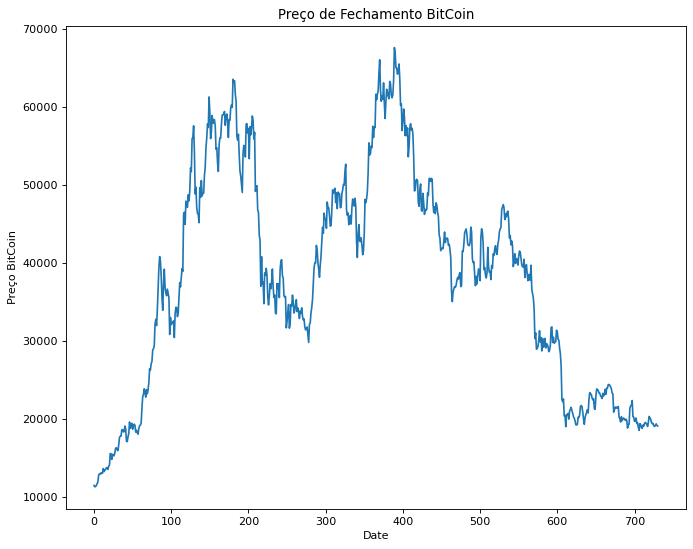

In [ ]:
# Plot
figure(figsize=(10, 8), dpi=80)
plt.plot(df["Close"])
plt.xlabel("Date")
plt.ylabel("Preço BitCoin")
plt.title("Preço de Fechamento BitCoin")
plt.show()

### Gerando Chute Inicial com MQO

Para gerar o chute inicial com Mínimos Quadrados Ordinários, irei usar a biblioteca `statsmodels` que possuí uma função OLS, no qual irá calcular o chute inicial usando o método ordinary least square.

In [ ]:
# defining the variables
x = df.index.tolist()
#x = df["Date"].dt.day.tolist()
y = df['Close'].tolist()
 
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     24.36
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           9.93e-07
Time:                        21:27:39   Log-Likelihood:                -7999.9
No. Observations:                 731   AIC:                         1.600e+04
Df Residuals:                     729   BIC:                         1.601e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.213e+04   1013.412     41.572      0.0

In [ ]:
#Nossos Chutes iniciais, beta0 e beta1
result.params

array([ 4.21296358e+04, -1.18624203e+01])

In [ ]:
#Chutes iniciais
beta0 = result.params[0]
print("Valor de beta_0 = {}".format(beta0))
beta1 = result.params[1]
print("Valor de beta_1 = {}".format(beta1))

Valor de beta_0 = 42129.63581685709
Valor de beta_1 = -11.862420294190288


## Mínimos Quadrados Descontados

Passo $1$ -  Chute inicial com Mínimos Quadrados Ordinários. Defina $\theta = 0.9$ e portanto $ var_1 = 1 - \theta^2$ e $ var_2 = (1 - \theta)^2$


Passo $2$ - A predição em T = 1 de T = 0
$$ y_{pred1} = \beta_0(0) + \beta_1(0)$$

Passo $3$ - Calcular o erro: $$ e_1(1) = y_1 - y_{pred1}$$


Passo $4$ - Tome $\beta_0(1) = \beta_0(0) + \beta_1(0) + var_1 \cdot e_1(1)$  e $\beta_1(1) =  \beta_1(0) + var_2 \cdot e_1(1)$


Passo $5$ - Repita os passos $2$ e $3$ encontrando $e_1$ e $(\beta_0(i), \beta_1(i))$ para uma base de dados.

In [ ]:
round(1 - 0.9**2, 4)

0.19

In [ ]:
def mqd(dataframe, beta0_init, beta1_init, theta, pred):
    beta0 = beta0_init
    beta1 = beta1_init
    var1 = round(1 - theta**2, 4)
    var2 = round((1-theta)**2, 4)
    #Criando listas vazias para armazenar os valroes dos erros e da variável preditora.
    yhat_list = []
    list_erros = []
    #Deixando o último index para previsão
    for i in range(len(df.Close)):
        yhat = beta0 + beta1
        yhat_list.append(yhat)
        yreal = df['Close'][i]
        error = yreal - yhat
        list_erros.append(error)
        
        beta0 = (beta0 + beta1) + 0.19*error
        beta1 = beta1 + 0.01*error
    
    yhat_pred = beta0 + beta1*pred
    yhat_list.append(yhat_pred)
    list_erros.append(None)
    #Cria um dataframe para ajudar na visualização a partir dos valores previstos e dos erros
    data= pd.DataFrame(list(zip(yhat_list, list_erros)),columns =['y_pred', 'error'])
    
    return data, beta0, beta1

In [ ]:
dataframe, beta_0_final, beta_1_final = mqd(df, beta0, beta1, theta = 0.9, pred = len(df.Close))

In [ ]:
dataframe.head()

,y_pred,error
0,42117.773397,-30622.423787
1,35981.426219,-24659.303172
2,30731.478926,-19373.377364
3,26292.123764,-14808.764389
4,22571.957422,-10829.920313


In [ ]:
#data plots
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = plt.gca()
ax.set_facecolor('#dddddd')

plt.title('Closing BitCoin Price. Out 15, 2020 - Out 15, 2022')
plt.xlabel("Tempo")
plt.ylabel("Closing BitCoin Price")

plt.plot(dataframe["y_pred"],linewidth = 2,label="Actual",color='red')
#plt.plot(e_s,linewidth=1,label="exponential_smoothing",color="#88CCEE")
plt.plot(m_a_s,linewidth=1,label="moving_avarage_smoothing",color="red")
#plt.plot(d_e_s,linewidth=1,label="double_exponential_smoothing",color="#117733")
#plt.plot(t_e_s,linewidth=1,label="triple_exponential_smoothing",color="red")

plt.legend(fontsize=9)
plt.show()

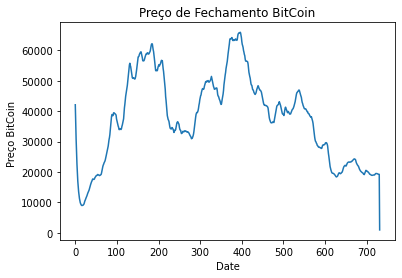

In [ ]:
# Plot
plt.plot(dataframe["y_pred"])

# Labelling 

plt.xlabel("Date")
plt.ylabel("Preço BitCoin ")
plt.title("Preço de Fechamento BitCoin")

# Display

plt.show()

In [ ]:
#Valor final de beta_0
beta_0_final

1.3914426781152602e+261

In [ ]:
#Valor final de beta_1
beta_1_final

2.473675872204907e+261

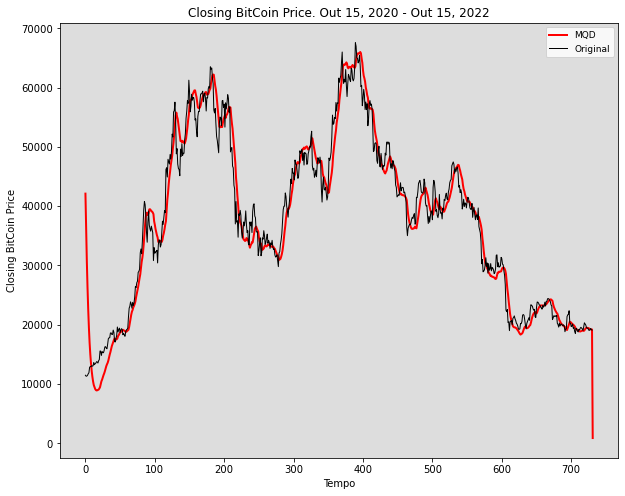

In [ ]:
#data plots
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1, 1, 1)
ax = plt.gca()
ax.set_facecolor('#dddddd')

plt.title('Preço Fechamento Bitcoin. Out 15, 2020 - Out 15, 2022')
plt.xlabel("Tempo")
plt.ylabel("Preço Fechamento Bitcoin")

plt.plot(dataframe["y_pred"],linewidth = 2,label="MQD",color='red')
plt.plot(df["Close"],linewidth=1,label="Original",color="black")


plt.legend(fontsize=9)
plt.show()

# Médias Moveis 

In [ ]:
def moving_avarage_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

In [ ]:
time_series = np.array(df['Close'])
m_a_s = moving_avarage_smoothing(df["Close"],4)
m_a_s_1 = moving_avarage_smoothing(time_series,12)
m_a_s_2 = moving_avarage_smoothing(df["Close"],50)
m_a_s_3 = moving_avarage_smoothing(df["Close"],100)


<Figure size 432x288 with 0 Axes>

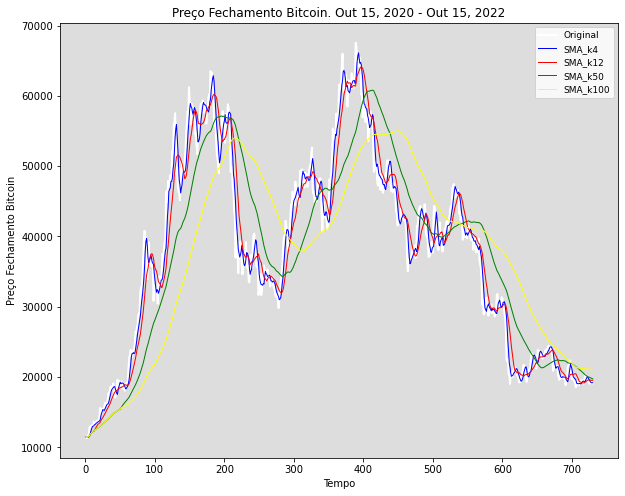

In [ ]:
#Gráfico
fig = plt.figure()
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1, 1, 1)
ax = plt.gca()
ax.set_facecolor('#dddddd')

plt.title('Preço Fechamento Bitcoin. Out 15, 2020 - Out 15, 2022')
plt.xlabel("Tempo")
plt.ylabel("Preço Fechamento Bitcoin")

plt.plot(time_series, linewidth = 2, label="Original",color='white')
plt.plot(m_a_s,linewidth=1,label="SMA_k4",color="blue")
plt.plot(m_a_s_1, linewidth=1,label="SMA_k12",color="red")
plt.plot(m_a_s_2,linewidth=1,label="SMA_k50",color="green")
plt.plot(m_a_s_3,linewidth=1,label="SMA_k100",color="yellow")


plt.legend(fontsize=9)
plt.show()

# Suavização Exponencial

In [ ]:
def exponential_smoothing(X,alpha):
    S = np.zeros(X.shape[0])
    S[0] = X[0]
    for t in range(1,X.shape[0]):
        S[t] = alpha * X[t-1] + (1- alpha) * S[t-1]
    return S

In [ ]:
e_s = exponential_smoothing(time_series,0.1)
e_s_2 = exponential_smoothing(time_series,0.3)
e_s_3 = exponential_smoothing(time_series,0.5)

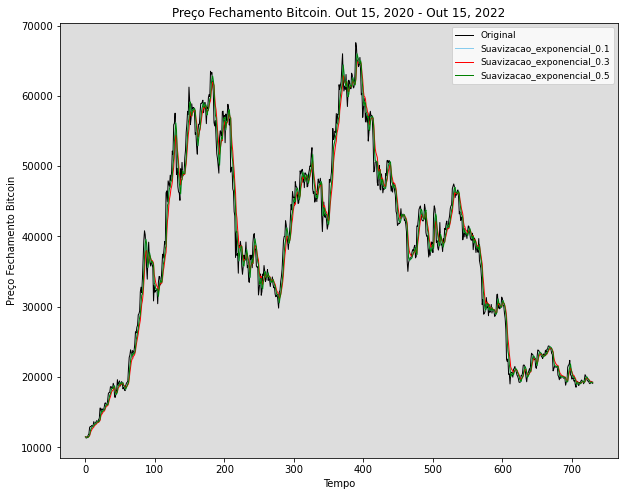

In [ ]:
#Gráfico
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1, 1, 1)
ax = plt.gca()
ax.set_facecolor('#dddddd')

plt.title('Preço Fechamento Bitcoin. Out 15, 2020 - Out 15, 2022')
plt.xlabel("Tempo")
plt.ylabel("Preço Fechamento Bitcoin")

plt.plot(df["Close"],linewidth=1,label="Original",color="black")
plt.plot(e_s,linewidth=1,label="Suavizacao_exponencial_0.1",color="#88CCEE")
plt.plot(e_s_2,linewidth=1,label="Suavizacao_exponencial_0.3",color="red")
plt.plot(e_s_3,linewidth=1,label="Suavizacao_exponencial_0.5",color="green")


plt.legend(fontsize=9)
plt.show()

# Suavização Exponêncial Dupla

In [ ]:
def double_exponential_smoothing(X,alpha,beta):
    S,A,B = (np.zeros( X.shape[0] ) for i in range(3))
    S[0] = X[0]
    for t in range(1,X.shape[0]):
        A[t] = alpha * X[t] + (1- alpha) * S[t-1]
        B[t] = alpha * (A[t] - A[t-1]) + (1 - alpha) * B[t-1]
        S[t] = A[t] + B[t]
    return S

In [ ]:
d_e_s = double_exponential_smoothing(df['Close'],0.5,0.1)
d_e_s_2 = double_exponential_smoothing(df['Close'],0.5,0.5)
d_e_s_3 = double_exponential_smoothing(df['Close'],0.1,0.5)
#d_e_s = double_exponential_smoothing(df['Close'],0.5,0.1)

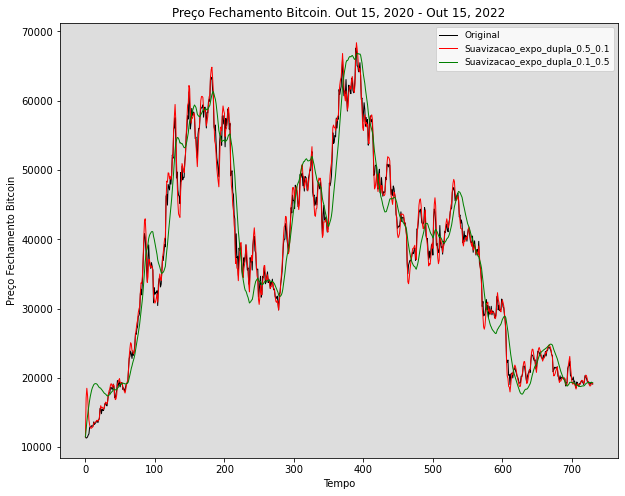

In [ ]:
#Gráfico
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1, 1, 1)
ax = plt.gca()
ax.set_facecolor('#dddddd')

plt.title('Preço Fechamento Bitcoin. Out 15, 2020 - Out 15, 2022')
plt.xlabel("Tempo")
plt.ylabel("Preço Fechamento Bitcoin")

plt.plot(df["Close"],linewidth=1,label="Original",color="black")
plt.plot(d_e_s,linewidth=1,label="Suavizacao_expo_dupla_0.5_0.1",color="red")
plt.plot(d_e_s_3,linewidth=1,label="Suavizacao_expo_dupla_0.1_0.5",color="green")


plt.legend(fontsize=9)
plt.show()

## Comparando as Técnicas

<Figure size 432x288 with 0 Axes>

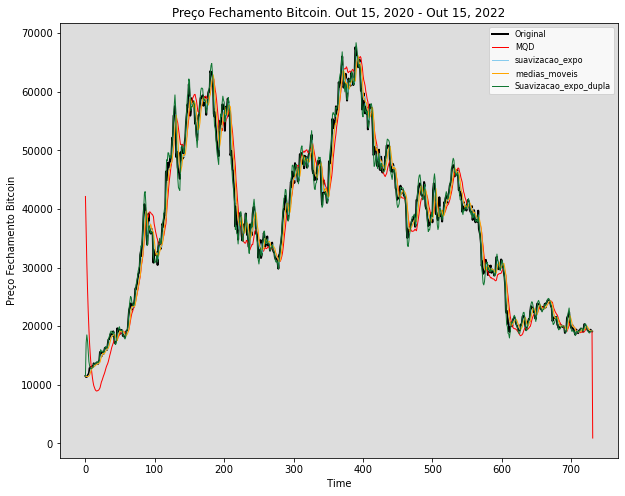

In [ ]:
#Técnicas de Suavização
m_a_s = moving_avarage_smoothing(df['Close'],4)
e_s = exponential_smoothing(df['Close'],0.5)
d_e_s = double_exponential_smoothing(df['Close'],0.5,0.1)

#Gráfico

fig = plt.figure()
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1, 1, 1)
ax = plt.gca()
ax.set_facecolor('#dddddd')

plt.title('Preço Fechamento Bitcoin. Out 15, 2020 - Out 15, 2022')
plt.xlabel(" Time ")
plt.ylabel("Preço Fechamento Bitcoin")

plt.plot(df["Close"],linewidth = 2,label="Original",color='black')
plt.plot(dataframe["y_pred"],linewidth = 1,label="MQD",color='red')
plt.plot(e_s,linewidth=1,label="suavizacao_expo",color="#88CCEE")
plt.plot(m_a_s,linewidth=1,label="medias_moveis",color="orange")
plt.plot(d_e_s,linewidth=1,label="Suavizacao_expo_dupla",color="#117733")

plt.legend(fontsize=8)
plt.show()